In [1]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib

import os
import sys

#import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable


import torchvision
import torchvision.transforms as transforms

In [2]:
matplotlib.rcParams['figure.figsize'] = (20,10)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(torch.version.cuda)
print(device)
#Ikke i brug endnu

9.0.176
cuda:0


## Kode til at gemme modeltilstande

In [4]:
def SaveState(model):
    x = datetime.datetime.now()
    filename = '../checkpoints/model_state_%s_%.4f.pt' % (x.strftime("%Y%m%d-%H%M"), acc)
    torch.save(model.state_dict(), filename)
    print('Model saved as:\n%s' % os.path.abspath(filename))
    
def LoadState(filename):
    model = torch.load(filename)
    model.eval()
    return model

## Indlæs data
Det antages at dataen ligger i `'../data'`

In [5]:
data_raw = np.load('../data/cullpdb+profile_5926.npy')

## Omform data

In [6]:
data = data_raw.reshape((-1,700,57))

amino_acid_recidues  = data[...,:22]
amino_seq_profiles   = data[...,35:]
sec_structure_labels = data[...,22:31]
sec_structure_actual_labels = np.argmax(sec_structure_labels, axis=2).reshape((-1, 700, 1))
solvent_access       = data[...,33:35]

ext_x = np.concatenate((amino_acid_recidues, amino_seq_profiles), axis=2)

x = ext_x
#x = amino_acid_recidues
y = np.concatenate((sec_structure_actual_labels, solvent_access), axis=2)
#y = solvent_access

input_channels  = x.shape[2]
output_channels = 9 #y.shape[2]

print('Kanaler:\nInput:  %d\nOutput: %d' % (input_channels, output_channels))

print('Fuldt datasæt shape:')
print('X: ', x.shape)
print('Y: ', y.shape)

y_train_unrot = y[:5430]
y_test_unrot = y[5435:5690]
y_validation_unrot = y[5690:5926]

#x = x.reshape(-1,22,700)
#y = y.reshape(-1,9,700)
x = np.rot90(x, axes=(1,2))
#y = np.rot90(y)#, axes=1)

x = np.flip(x, 1)
#y = np.flip(y, 1)

print('Fuldt datasæt vendt shape:')
print('X: ', x.shape)
print('Y: ', y.shape)

x_train = x[:5430]
y_train = y[:5430]

x_test = x[5435:5690]
y_test = y[5435:5690]

x_validation = x[5690:5926]
y_validation = y[5690:5926]

print('Splittet ud i training og testing:')
print('(Train) X: ', x_train.shape)
print('(Train) Y: ', y_train.shape)
print('(Test)  X: ', x_test.shape)
print('(Test)  Y: ', y_test.shape)
print('(Validation)  X: ', x_validation.shape)
print('(Validation)  Y: ', y_validation.shape)

torch_X_train = torch.from_numpy(x_train).type(torch.FloatTensor).to(device)
torch_Y_train = torch.from_numpy(y_train).type(torch.FloatTensor).to(device)
torch_X_test  = torch.from_numpy(x_test).type(torch.FloatTensor).to(device)
torch_Y_test  = torch.from_numpy(y_test).type(torch.FloatTensor).to(device)
torch_X_validation  = torch.from_numpy(x_validation).type(torch.FloatTensor).to(device)
torch_Y_validation  = torch.from_numpy(y_validation).type(torch.FloatTensor).to(device)

Kanaler:
Input:  44
Output: 9
Fuldt datasæt shape:
X:  (5926, 700, 44)
Y:  (5926, 700, 3)
Fuldt datasæt vendt shape:
X:  (5926, 44, 700)
Y:  (5926, 700, 3)
Splittet ud i training og testing:
(Train) X:  (5430, 44, 700)
(Train) Y:  (5430, 700, 3)
(Test)  X:  (255, 44, 700)
(Test)  Y:  (255, 700, 3)
(Validation)  X:  (236, 44, 700)
(Validation)  Y:  (236, 700, 3)


## Sæt data sammen i DataLoader

In [7]:
BATCH_SIZE = 4 # 250 har virket godt før

train = torch.utils.data.TensorDataset(torch_X_train, torch_Y_train)
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True)

## Definér modellen

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(
                in_channels=input_channels,       
                out_channels=layer_width,      
                kernel_size=kernel_sizes[0],        
                stride=1,             
                padding=int(kernel_sizes[0]/2),            
            ),                        
            nn.ReLU(),                
        )
        self.conv2 = nn.Sequential(   
            nn.Conv1d(
                in_channels=layer_width,       
                out_channels=layer_width,      
                kernel_size=kernel_sizes[1],        
                stride=1,             
                padding=int(kernel_sizes[1]/2),            
            ),                        
            nn.ReLU(),                
        )
        self.conv3 = nn.Sequential(   
            nn.Conv1d(
                in_channels=layer_width,       
                out_channels=layer_width,      
                kernel_size=kernel_sizes[2],        
                stride=1,             
                padding=int(kernel_sizes[2]/2),            
            ),                        
            nn.ReLU(),                
        )
#        self.conv4 = nn.Sequential(   
#            nn.Conv1d(
#                in_channels=layer_width,       
#                out_channels=layer_width,      
#                kernel_size=kernel_sizes[3],        
#                stride=1,             
#                padding=int(kernel_sizes[3]/2),            
#            ),                        
#            nn.ReLU(),                
#        )
#        self.conv5 = nn.Sequential(   
#            nn.Conv1d(
#                in_channels=layer_width,       
#                out_channels=layer_width,      
#                kernel_size=kernel_sizes[4],        
#                stride=1,             
#                padding=int(kernel_sizes[4]/2),            
#            ),                        
#            nn.ReLU(),                
#        )
        self.out = nn.Sequential(     
            nn.Conv1d(
                in_channels=layer_width,       
                out_channels=3,       
                kernel_size=kernel_sizes[3],        
                stride=1,             
                padding=int(kernel_sizes[3]/2),            
            ),
            #nn.ReLU(),
            #nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        #x = self.conv4(x)
        #x = self.conv5(x)
        output = self.out(x)
        rel_solvent = output[:,0,:]
        abs_solvent = output[:,1,:]
        return rel_solvent, abs_solvent #, x    # return x for visualization

## Instantiér modellen

In [9]:
layer_width = 90
kernel_sizes = [5, 7, 9, 11]#, 13, 15]

cnn = CNN().to(device)
print(cnn)
print('Model is on device: "%s"' % device)
# Hyperparametre
LR = 0.0005              # learning rate

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = nn.BCEWithLogitsLoss()  #Binary Cross Entropy Loss
sigge = nn.Sigmoid()
#loss_func = nn.CrossEntropyLoss()
#validation_loss_func = nn.BCELoss()
#test_loss_func = nn.BCELoss()

CNN(
  (conv1): Sequential(
    (0): Conv1d(44, 90, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(90, 90, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv1d(90, 90, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): ReLU()
  )
  (out): Sequential(
    (0): Conv1d(90, 3, kernel_size=(11,), stride=(1,), padding=(5,))
  )
)
Model is on device: "cuda:0"


In [10]:
# Til visualisering senere
losses     = []
solv_rel_accs_v  = []
solv_rel_accs_t  = []
solv_abs_accs_v  = []
solv_abs_accs_t  = []
steps      = []
steps_cum  = []
epochs     = []
collected  = []

## Funktion til at måle accuracy

In [11]:
def CalculateAccuracy(calc_values_rel, calc_values_abs, real_values):
    NoSeq = 8
    
    real_labels           = real_values[:,:,0]     
    real_values_relsolv   = real_values[:,:,1]
    real_values_abssolv   = real_values[:,:,2]
    
    real_mask = real_labels == NoSeq                        # Lav maske af dem der er NoSeq
    
    calc_relsolv = sigge(calc_values_rel).cpu().detach().numpy()                         # Kør sigmoid funktion og omform til numpy    
    calc_abssolv = sigge(calc_values_abs).cpu().detach().numpy()                         # Kør sigmoid funktion og omform til numpy
    
    calc_relsolv = np.around(calc_relsolv)                                        # Afrund til enten 0 eller 1
    calc_abssolv = np.around(calc_abssolv)                                        # Afrund til enten 0 eller 1
    
    correct_relsolv = calc_relsolv == real_values_relsolv                         # Lav en matrice af korrekte forudsigelser
    correct_relsolv_masked = np.ma.masked_array(correct_relsolv, real_mask)       # Filtrér dem er er NoSeq
    
    correct_abssolv = calc_abssolv == real_values_abssolv                         # Lav en matrice af korrekte forudsigelser
    correct_abssolv_masked = np.ma.masked_array(correct_abssolv, real_mask)       # Filtrér dem er er NoSeq
    
    relsolv_mean   = np.mean(correct_relsolv_masked)                              # Tag gennemsnittet af relativ solvent-sættet
    abssolv_mean   = np.mean(correct_abssolv_masked)                              # Tag gennemsnittet af absolut solvent-sættet    
    
    return relsolv_mean, abssolv_mean

## Træn modellen

In [12]:
EPOCH = 20

step_cum = -1
for epoch in range(EPOCH):
    print('\nEpoch: ', epoch+1)
    for step, (b_x, b_y) in enumerate(train_loader):
        step_cum += 1
        relsolv, abssolv = cnn(b_x)              # cnn output
        loss1 = loss_func(relsolv, b_y[:,:,1])   # cross entropy loss
        loss2 = loss_func(abssolv, b_y[:,:,2])   # cross entropy loss
        loss_sum = loss1 + loss2
        optimizer.zero_grad()           # clear gradients for this training step
        loss_sum.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            relsolv_v, abssolv_v = cnn(torch_X_validation)
            #vloss = loss_func(test_output, torch_Y_validation)
            rel_acc_v, abs_acc_v = CalculateAccuracy(relsolv_v, abssolv_v, y_validation_unrot)

            relsolv_t, abssolv_t = cnn(torch_X_test)
            #vloss = loss_func(test_output, torch_Y_validation)
            rel_acc_t, abs_acc_t = CalculateAccuracy(relsolv_t, abssolv_t, y_test_unrot)
            #test_output = cnn(torch_X_test)
            #tloss = loss_func(test_output, torch_Y_test)
            #t_acc = CalculateAccuracy(test_output, y_test_unrot)
            #sys.stdout.write('\rStep [%d]:\tTrain:[Loss: %.5f] \t Validation:[Accuracy: %.4f%%]  Test:[Accuracy: %.4f%%]' % (step, loss.item(), v_acc*100, t_acc*100))
            sys.stdout.write('\rValidation:[Relative: %.4f, Absolute: %.4f]\tTest:[Relative: %.4f, Absolute: %.4f]' % (rel_acc_v, abs_acc_v, rel_acc_t, abs_acc_t))
            
            solv_rel_accs_v.append(rel_acc_v)
            solv_rel_accs_t.append(rel_acc_t)
            solv_abs_accs_v.append(abs_acc_v)
            solv_abs_accs_t.append(abs_acc_t)
            
            #collected.append([step_cum, vloss.item(), acc, epoch])
            #epochs.append(epoch)
            #losses.append(vloss.item())
            #v_accuracies_single.append(v_acc)
            #t_accuracies_single.append(t_acc)
            #steps.append(step)
            steps_cum.append(step_cum)

relsolv_v, abssolv_v = cnn(torch_X_validation)
#vloss = loss_func(test_output, torch_Y_validation)
rel_acc_v, abs_acc_v = CalculateAccuracy(relsolv_v, abssolv_v, y_validation_unrot)


relsolv_t, abssolv_t = cnn(torch_X_test)
#vloss = loss_func(test_output, torch_Y_validation)
rel_acc_t, abs_acc_t = CalculateAccuracy(relsolv_t, abssolv_t, y_test_unrot)
print('\n%.4f\t%.4f\t%.4f\t%.4f' % (rel_acc_v, abs_acc_v, rel_acc_t, abs_acc_t))
            
print('\nDone training.')


Epoch:  1
Validation:[Relative: 0.8101, Absolute: 0.7940]	Test:[Relative: 0.8057, Absolute: 0.7878]
Epoch:  2
Validation:[Relative: 0.8217, Absolute: 0.8057]	Test:[Relative: 0.8172, Absolute: 0.8010]
Epoch:  3
Validation:[Relative: 0.8232, Absolute: 0.8075]	Test:[Relative: 0.8192, Absolute: 0.8040]
Epoch:  4
Validation:[Relative: 0.8259, Absolute: 0.8100]	Test:[Relative: 0.8221, Absolute: 0.8042]
Epoch:  5
Validation:[Relative: 0.8224, Absolute: 0.8108]	Test:[Relative: 0.8213, Absolute: 0.8072]
Epoch:  6
Validation:[Relative: 0.8280, Absolute: 0.8126]	Test:[Relative: 0.8250, Absolute: 0.8071]
Epoch:  7
Validation:[Relative: 0.8281, Absolute: 0.8124]	Test:[Relative: 0.8227, Absolute: 0.8058]
Epoch:  8
Validation:[Relative: 0.8299, Absolute: 0.8139]	Test:[Relative: 0.8251, Absolute: 0.8087]
Epoch:  9
Validation:[Relative: 0.8294, Absolute: 0.8148]	Test:[Relative: 0.8274, Absolute: 0.8097]
Epoch:  10
Validation:[Relative: 0.8295, Absolute: 0.8146]	Test:[Relative: 0.8259, Absolute: 0.8085

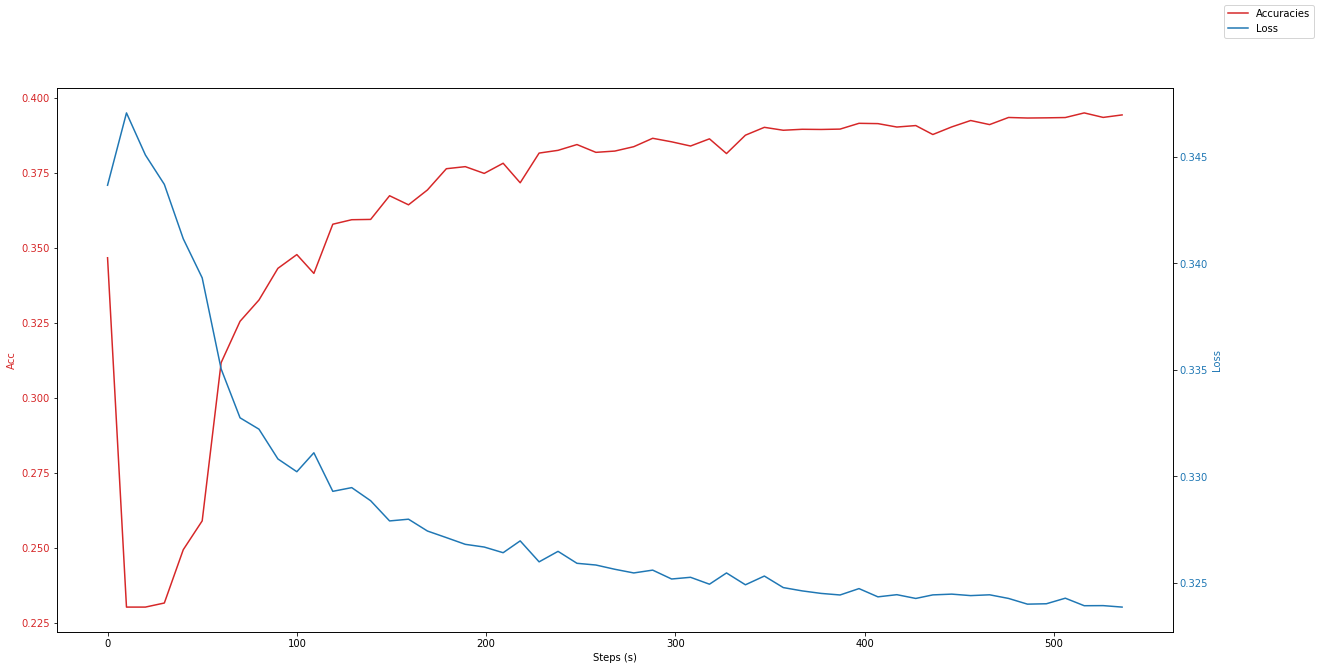

In [47]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Steps (s)')
ax1.set_ylabel('Acc', color=color)
ax1.plot(steps_cum, accuracies, color=color, label='Accuracies')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)  # we already handled the x-label with ax1
ax2.plot(steps_cum, losses, color=color, label='Loss')
ax2.tick_params(axis='y', labelcolor=color)
fig.legend()
#fig.tight_layout()  # otherwise the right y-label is slightly clipped

## Endelig test af accuracy

In [16]:
print('Running on the test set:')
test_output = cnn(torch_X_test)
tloss = loss_func(test_output, torch_Y_test)
acc = CalculateAccuracy(test_output, y_test_unrot)
sys.stdout.write('Loss: %.5f,\tAccuracy: %.4f%%' % (tloss.item(), acc*100))

Running on the test set:
Loss: 0.25504,	Accuracy: 69.8619%

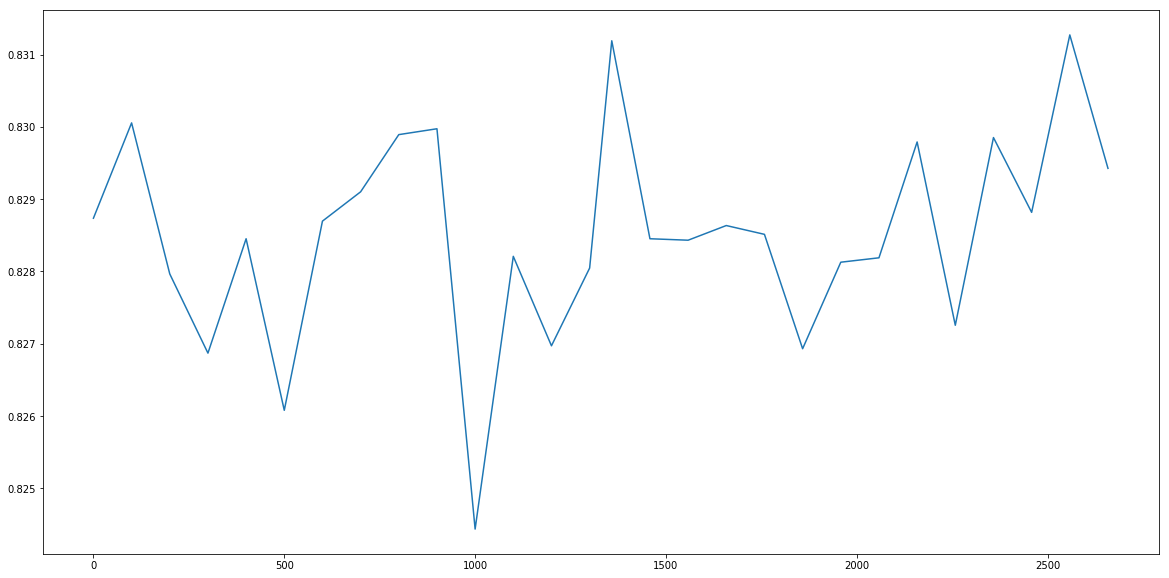

In [50]:
plt.plot( steps_cum, rel_accs_v)

In [13]:

%store solv_rel_accs_v  
%store solv_rel_accs_t  
%store solv_abs_accs_v  
%store solv_abs_accs_t  

Stored 'solv_rel_accs_v' (list)
Stored 'solv_rel_accs_t' (list)
Stored 'solv_abs_accs_v' (list)
Stored 'solv_abs_accs_t' (list)
